In [2]:
import json

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import torch


from collections import Counter

from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from src.word_to_embedding import WordToEmbedding

RANDOM_STATE = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
w2e = WordToEmbedding()

/home/lyubolp/detecting-loanwords/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/lyubolp/detecting-loanwords/src/transcription_dataset_single_word.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(row[0], str):
/home/lyubolp/detecting-loanwords/src/transcription_dataset_single_word.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

KeyboardInterrupt: 

In [ ]:
def generate_label_mapping(data: pd.DataFrame):
    label_to_id = {item: i for i, item in enumerate(set(data['произход']))}
    id_to_label = {index: label for label, index in label_to_id.items()}

    return label_to_id, id_to_label

In [ ]:
class LoanwordsDataset(Dataset):
    def __init__(self, data: pd.DataFrame, label_to_id: dict[str, int], embeddeing_engine: WordToEmbedding):
        self.__data = data
        self.__len = self.__data.shape[0]
        
        self.__label_mapping = label_to_id
        self.__embeddeing_engine = embeddeing_engine


    def __len__(self):
        return self.__len

    def __getitem__(self, index) -> tuple[str, str]:
        entry = self.__data.iloc[index]

        word = entry['дума']
        origin = entry['произход']
        word_tensor = self.__embeddeing_engine.get_embedding(word)
        origin_tensor = self.__label_mapping[origin]

        word_tensor_shape = word_tensor.shape
        word_tensor = word_tensor.reshape((word_tensor_shape[0], 1, word_tensor_shape[1]))

        return word, word_tensor, origin, origin_tensor


In [ ]:
class LoanwordClassifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.__hidden_size = hidden_size

        self.__i2h = nn.Linear(input_size + self.__hidden_size, self.__hidden_size).to(device)
        self.__h2o = nn.Linear(hidden_size, output_size).to(device)
        self.__softmax = nn.LogSoftmax(dim=1).to(device)

    def forward(self, input_tensor, hidden):
        combined = torch.cat((input_tensor.to(device), hidden.to(device)), 1).to(device)
        hidden = self.__i2h(combined).to(device)
        output = self.__h2o(hidden).to(device)
        output = self.__softmax(output).to(device)

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.__hidden_size)

In [6]:
def category_from_output(output, id_to_label):
    top_n, top_i = output.topk(1)

    category_i = top_i[0].item()
    return id_to_label[category_i], category_i

In [7]:
def train_epoch(model: LoanwordClassifier, train_dataloader, loss_fn,  id_to_label, learning_rate=0.005):
    sum_loss = 0
    for word, word_tensor, label, label_tensor in tqdm(train_dataloader):
        word_tensor = word_tensor[0]
        hidden = model.init_hidden()
        model.zero_grad()

        for syllable_embedding in word_tensor:
            output, hidden = model(syllable_embedding, hidden)
        
        loss = loss_fn(output.to(device), label_tensor.to(device))
        loss.backward()

        for p in model.parameters():
            p.data.add_(p.grad.data, alpha=-learning_rate)
        
        sum_loss += loss.item()

    return sum_loss / len(train_dataloader)

In [8]:
# Train & Test loop
def train_loop(model: LoanwordClassifier, train_dataloader, epochs, loss_fn, id_to_label, learning_rate=0.005):
    for epoch in range(epochs):
        
        epoch_loss = train_epoch(model, train_dataloader, loss_fn, id_to_label, learning_rate)
        print(f"Epoch: {epoch}, loss: {epoch_loss:>7f}")

In [9]:
def test_loop(model: LoanwordClassifier, test_dataloader, id_to_label):
    predicted_ids = []
    actual_ids = []
    for word, word_tensor, label, label_tensor in tqdm(test_dataloader):
        word_tensor = word_tensor[0]

        hidden = model.init_hidden()

        for syllable_embedding in word_tensor:
            output, hidden = model(syllable_embedding, hidden)

        predicted_label, predicted_label_id = category_from_output(output, id_to_label)
        # print(predicted_label, predicted_label_id)
        predicted_ids.append(predicted_label_id)
        actual_ids.append(label_tensor)
    
    return predicted_ids, actual_ids

In [109]:
def get_distribution(train_data, label_to_id):
    counts = train_data['произход'].value_counts(normalize=True)
    weights = sorted(zip(counts.keys(), counts), key=lambda x: label_to_id[x[0]])
    weights = list(map(lambda x: x[1], weights))
    return torch.Tensor(weights)

In [1]:
path = '/mnt/d/Projects/masters-thesis/data/loanwords.csv'
data = pd.read_csv(path)
label_to_id, id_to_label = generate_label_mapping(data)

# Running the model with normal labels 
train_data, test_data = train_test_split(data, random_state=RANDOM_STATE)


train_dataset = LoanwordsDataset(train_data, label_to_id, embeddeing_engine=w2e)
train_dataloader = DataLoader(train_dataset)

test_dataset = LoanwordsDataset(test_data, label_to_id, embeddeing_engine=w2e)
test_dataloader = DataLoader(test_dataset)

model = LoanwordClassifier(input_size=512, hidden_size=1024, output_size=len(label_to_id))
distribution = get_distribution(train_data, label_to_id)
loss_fn = nn.NLLLoss(distribution)


NameError: name 'pd' is not defined

In [114]:
train_loop(model, train_dataloader, epochs=10, loss_fn=loss_fn, id_to_label=id_to_label)

100%|██████████| 31501/31501 [05:58<00:00, 87.89it/s] 


Epoch: 0, loss: 0.871497


100%|██████████| 31501/31501 [06:02<00:00, 86.85it/s]


Epoch: 1, loss: 0.787698


100%|██████████| 31501/31501 [05:53<00:00, 89.09it/s] 


Epoch: 2, loss: 0.757763


100%|██████████| 31501/31501 [05:33<00:00, 94.40it/s] 


Epoch: 3, loss: 0.742370


100%|██████████| 31501/31501 [05:37<00:00, 93.39it/s] 


Epoch: 4, loss: 0.736737


100%|██████████| 31501/31501 [06:15<00:00, 83.84it/s]


Epoch: 5, loss: 0.738159


100%|██████████| 31501/31501 [05:57<00:00, 88.04it/s] 


Epoch: 6, loss: 0.744995


100%|██████████| 31501/31501 [05:57<00:00, 88.22it/s] 


Epoch: 7, loss: 0.759105


100%|██████████| 31501/31501 [05:58<00:00, 87.92it/s]


Epoch: 8, loss: 0.772743


100%|██████████| 31501/31501 [05:51<00:00, 89.65it/s] 

Epoch: 9, loss: 0.785232


In [115]:
from datetime import datetime
today_date = datetime.today().strftime('%Y-%m-%d')
torch.save(model.state_dict(), f'models/classifier-{today_date}-1024hidden-10epochs.pth')

In [116]:
from datetime import datetime
today_date = datetime.today().strftime('%Y-%m-%d')

id_to_label_json = json.dumps(id_to_label)
with open(f'models/id-to-label-{today_date}-1024hidden-10epochs.json', 'w+') as fp:
    fp.write(id_to_label_json)


label_to_id_json = json.dumps(label_to_id)
with open(f'models/label-to-id-{today_date}-1024hidden-10epochs.json', 'w+') as fp:
    fp.write(label_to_id_json)

In [11]:
state_dict_path = 'models/classifier-2024-01-10-1024hidden-10epochs.pth'
model.load_state_dict(torch.load(state_dict_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [117]:
p, a = test_loop(model, test_dataloader, id_to_label)
a = [t.item() for t in a]

100%|██████████| 10501/10501 [01:01<00:00, 170.40it/s]


In [118]:
results = list(zip(p, a))
correct = sum(1 for p, a in results if p == a)


f'correct: {correct}, accuracy: {correct / len(results) * 100:.2f}%, f1: {f1_score(a, p, average="weighted"):.3f}'

'correct: 7577, accuracy: 72.16%, f1: 0.690'

/tmp/ipykernel_1247/575425773.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(label_to_id.keys()), rotation=90)
/tmp/ipykernel_1247/575425773.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(label_to_id.keys()))


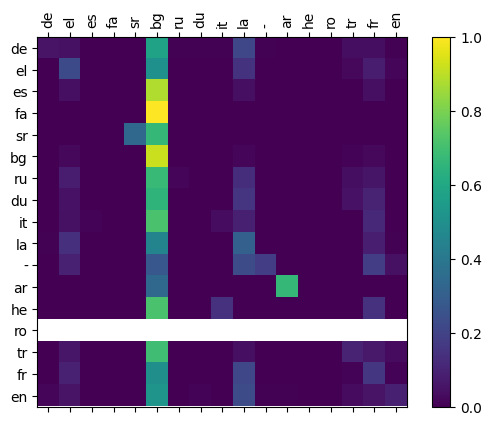

In [119]:
confusion = torch.zeros(len(label_to_id), len(label_to_id))
for predicted, actual in results:
    confusion[actual][predicted] += 1

for i in range(len(label_to_id)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(label_to_id.keys()), rotation=90)
ax.set_yticklabels([''] + list(label_to_id.keys()))

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()